In [1]:
import sncosmo
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [2]:
from scipy.integrate import cumulative_trapezoid as cumtrapz
import astropy.constants as c
import astropy.units as u
import astropy.cosmology.units as cu
from scipy import interpolate
from astropy.cosmology import WMAP9 as cosmo
import extinction
import math
import scipy.stats as stats
from scipy.interpolate import CubicSpline

# DAY_CGS = 86400.0
# M_SUN_CGS = c.M_sun.cgs.value
# C_CGS = c.c.cgs.value
# beta = 13.7
# KM_CGS = u.km.cgs.scale
# RAD_CONST = KM_CGS * DAY_CGS
# STEF_CONST = 4. * np.pi * c.sigma_sb.cgs.value
# ANG_CGS = u.Angstrom.cgs.scale
# MPC_CGS = u.Mpc.cgs.scale

# DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
# TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
# FLUX_CONST = 4.0 * np.pi * (
#         2.0 * c.h * c.c ** 2 * np.pi).cgs.value * u.Angstrom.cgs.scale
# X_CONST = (c.h * c.c / c.k_B).cgs.value

DAY_CGS = u.day
M_SUN_CGS = c.M_sun
C_CGS = c.c
beta = 13.7
KM_CGS = u.km

STEF_CONST = 4. * np.pi * c.sigma_sb
ANG_CGS = u.Angstrom
MPC_CGS = u.Mpc

DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
FLUX_CONST = 4.0 * np.pi * (
        2.0 * c.h * c.c ** 2 * np.pi) * u.Angstrom
X_CONST = (c.h * c.c / c.k_B)

In [76]:
class ArnettSource(sncosmo.Source):

    _param_names = ['mej', 'fni', 'vej']
    param_names = ['mej', 'fni', 'vej']

    param_names_latex = ['M_{ej}', 'f_{Ni}', 'v_{ej}']   # used in plotting display

    def __init__(self, phase, wave, params=None, name=None, version=None):
        
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        self._tfloor = 3000 * u.K
        if params is not None:
            self._parameters = params
        else:
            self._parameters = [0, 0, 0]

    def _blackbody_flux(self, temperature, radius, wavelength):
        # Convert wavelength from Angstrom to cm

        all_fluxes = np.zeros((len(temperature), len(wavelength))) * (u.erg / (u.s * u.AA)).decompose()
        for i in range(len(temperature)):
            temp = temperature[i]
            rad = radius[i]

            # Planck function numerator: 2hc^2 / λ^5
            numerator = (2 * c.h * c.c**2 / wavelength**5).decompose()

            # Exponent of the Planck function
            exponent = (c.h * c.c / (wavelength * c.k_B * temp)).decompose()

            # Compute denominator, stripping unit to pass into np.exp safely
            denominator = np.exp(exponent.value) - 1

            # Spectral radiance: Planck's law in SI units (W / (m^2 m))
            flux_density = numerator / denominator  # Units: W / (m²·m)

            # Convert to flux at the source: multiply by 4πR²
            flux_final = flux_density * (4 * np.pi * rad**2)

            # Assign to all_fluxes
            all_fluxes[i, :] = flux_final
        return all_fluxes 


    def _gen_arnett_model(self, t, wvs, theta):
        mej, fni, vej = theta
        mej = (mej * u.Msun).to(u.g)
        vej = vej * u.km/u.s
        t = t * u.day
        wvs = wvs * u.AA
        tfloor = self._tfloor
        # Convert to grams
        # mej = mej * M_SUN_CGS
        mni = mej * fni
        # Convert velocity to cm/s
        # vej = vej * 1e8
        vej = vej.to(u.cm / u.s)

        tni = 8.8 * u.day  # days
        tco = 111.3  * u.day # days
        epco = 6.8e9 * u.erg / u.g / u.s # erg/g/s
        epni = 3.9e10 * u.erg / u.g / u.s # erg/g/s
        opac = 0.1 *u.cm * u.cm/u.g
        texp = 0.000 * u.day
        # Diffusion timescale in days
        td = np.sqrt(2 * opac * mej / (13.7 * c.c * vej)).to(u.day)  # convert seconds to days
        # t_to_integrate = np.hstack((np.array(0.), t))
        t_to_integrate = np.linspace(0, np.max(t), 1000)
        
        
        # td = np.sqrt(2 * opac * mej / (13.7 * C_CGS * vej)) / 86400  # convert seconds to days
        integrand1 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni)
        integrand2 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco)

        # Luminosity calculation
        dense_luminosities = 2 * mni / (td) * np.exp(-t_to_integrate**2 / td**2) * \
              (((epni - epco) * cumtrapz(integrand1, t_to_integrate, initial=0) + 
               epco * cumtrapz(integrand2, t_to_integrate, initial=0)))*u.day # these should be erg/s
        
        # luminosities = dense_luminosities[1:]
        spline = CubicSpline(t_to_integrate, dense_luminosities)
        luminosities = spline(t) * u.erg / u.s
        # plt.plot(t, luminosities, 'o')
        # print(luminosities.unit)
        # print(dense_luminosities.unit)
        # # plt.plot(t_to_integrate, dense_luminosities, 'o')

        
        #Do BB calculation
        radius = (vej * ((t - texp) * ((t-texp)>=0))).to(u.cm)
        temperature = ((luminosities / (STEF_CONST * radius**2))**0.25).to(u.K)# * (1e52)**0.25
        gind = (temperature < tfloor) | np.isnan(temperature)
        temperature = np.nan_to_num(temperature)
        notgind = np.invert(gind)
        temperature = (0. * temperature) + (temperature * notgind) + (tfloor * gind)
        
        radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
        radius = radius.to(u.cm)

        fluxes = self._blackbody_flux(temperature, radius, wvs) # this is a luminosity density

        #fluxes = u.Quantity(fluxes, u.erg / (u.AA * u.s), copy=False)
        
        # divide luminosity density by 4pir^2 to get flux
        z = 0.25 * cu.redshift
        d_cm = z.to(u.cm, cu.redshift_distance(cosmo, kind="luminosity"))
        flux_density = fluxes / (4 * np.pi * d_cm**2) 
        # print(flux_density)
        return flux_density


    def _flux(self, phase, wave):
        # self._phase = phase
        # self._wave = wave
        return self._gen_arnett_model(phase, wave, self._parameters)

In [77]:
times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms
#wavelengths = [5000]
mej = 3
fni = 0.1
vej = 10000
arnett_source = ArnettSource(times, wavelengths, params=[mej, fni, vej])

In [78]:
max_flux = arnett_source.flux(times, wavelengths)


In [79]:
max_flux[9][9]

<Quantity 6.63779698e-20 1000 kg m / (cm2 s3)>

In [80]:
max_flux.shape

(100, 10)

In [81]:
max_flux[9][9]

<Quantity 6.63779698e-20 1000 kg m / (cm2 s3)>

In [82]:
# Calculate magnitude from flux
def get_magnitude(flux):
    fnu = ((wavelengths * u.angstrom)**2 * flux / c.c)
    m = -2.5*np.log10(fnu.to(u.Jy)[9]/(3631*u.Jy).decompose())
    # print(m)
    dpc =1020536167.755819 # z = 0.25 in pc
    return m - 5*(np.log10(dpc) - 1)


In [83]:
# Convert f_lambda to f_nu
fnu = ((wavelengths * u.angstrom)**2 * max_flux[9][9] / c.c).decompose()
print(fnu)

[8.85652298e-35 2.14305988e-34 3.94716641e-34 6.29797189e-34
 9.19547633e-34 1.26396797e-33 1.66305820e-33 2.11681833e-33
 2.62524835e-33 3.18834827e-33] kg / s2


In [84]:
fnu

<Quantity [8.85652298e-35, 2.14305988e-34, 3.94716641e-34, 6.29797189e-34,
           9.19547633e-34, 1.26396797e-33, 1.66305820e-33, 2.11681833e-33,
           2.62524835e-33, 3.18834827e-33] kg / s2>

In [85]:
fnu.to(u.Jy)[9]

<Quantity 3.18834827e-07 Jy>

In [86]:
# Apparent magnitude
m = -2.5*np.log10(fnu.to(u.Jy)[9]/(3631*u.Jy))
m

<Quantity 25.14115124>

In [87]:
# Absolute magnitude
dpc =10#1020536167.755819 # this is comoving distance for z = 0.25
m - 5*(np.log10(dpc) - 1)

<Quantity 25.14115124>

In [88]:
arnett_source = ArnettSource(times, wavelengths, params=[mej, fni, vej])
arnett_model = sncosmo.Model(source=arnett_source)
print(arnett_source)

class      : ArnettSource
name       : None
version    : None
phases     : [0.1, .., 100] days
wavelengths: [2000, .., 12000] Angstroms
parameters:
  mej = 3
  fni = 0.1
  vej = 10000


Text(0.5, 0, 'Days')

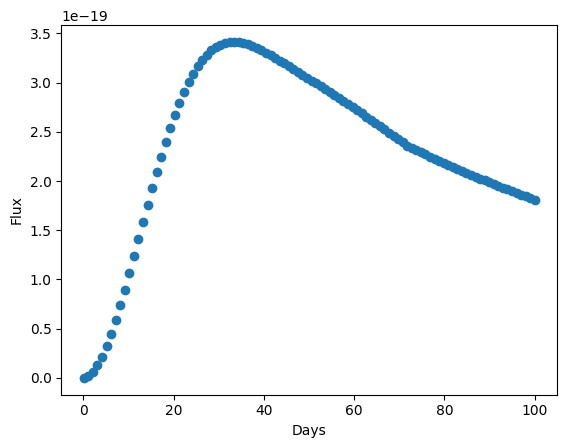

In [89]:
plt.plot(times, max_flux[:,8], 'o')
plt.ylabel("Flux")
plt.xlabel("Days")

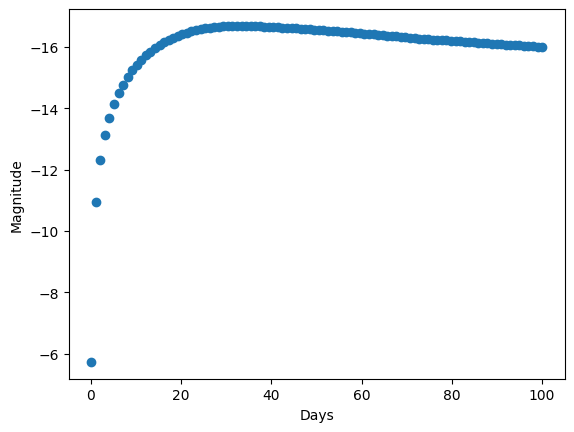

In [90]:
plt.plot(times, [get_magnitude(i) for i in max_flux[:,8]], 'o')
plt.ylabel("Magnitude")
plt.xlabel("Days")
plt.gca().invert_yaxis()

In [91]:
times1 = np.linspace(0.1,100,100) # days
times2 = np.linspace(0.1,100,10) # days
times3 = np.linspace(0.1,100,50) # days
times4 = np.linspace(0.1,100,20) # days



wavelengths = np.linspace(2000,12000,10) # Angstroms
#wavelengths = [5000]
mej = 3
fni = 0.1
vej = 10000
arnett_source = ArnettSource(times1, wavelengths, params=[mej, fni, vej])
fluxes1= arnett_source.flux(times1, wavelengths)
fluxes2= arnett_source.flux(times2, wavelengths)
fluxes3= arnett_source.flux(times3, wavelengths)
fluxes4= arnett_source.flux(times4, wavelengths)

# fluxes3= ArnettSource(times2, wavelengths, params=[mej, fni, vej]).flux(times2, wavelengths)

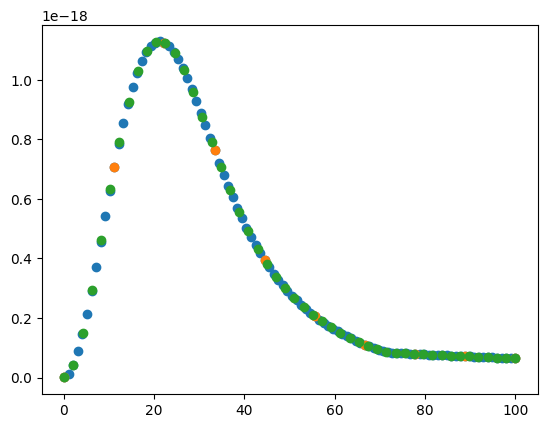

In [92]:
plt.plot(times1, fluxes1[:,3], 'o')
plt.plot(times2, fluxes2[:,3], 'o')
plt.plot(times3, fluxes3[:,3], 'o')

In [93]:
# This is sample data from SNCosmo... right now I'm only using it to get the band names
data = sncosmo.load_example_data()

In [94]:
times

array([  0.1       ,   1.10909091,   2.11818182,   3.12727273,
         4.13636364,   5.14545455,   6.15454545,   7.16363636,
         8.17272727,   9.18181818,  10.19090909,  11.2       ,
        12.20909091,  13.21818182,  14.22727273,  15.23636364,
        16.24545455,  17.25454545,  18.26363636,  19.27272727,
        20.28181818,  21.29090909,  22.3       ,  23.30909091,
        24.31818182,  25.32727273,  26.33636364,  27.34545455,
        28.35454545,  29.36363636,  30.37272727,  31.38181818,
        32.39090909,  33.4       ,  34.40909091,  35.41818182,
        36.42727273,  37.43636364,  38.44545455,  39.45454545,
        40.46363636,  41.47272727,  42.48181818,  43.49090909,
        44.5       ,  45.50909091,  46.51818182,  47.52727273,
        48.53636364,  49.54545455,  50.55454545,  51.56363636,
        52.57272727,  53.58181818,  54.59090909,  55.6       ,
        56.60909091,  57.61818182,  58.62727273,  59.63636364,
        60.64545455,  61.65454545,  62.66363636,  63.67

In [95]:
times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(200,12000,50) # Angstroms
arnett_source = ArnettSource(times, wavelengths, params=[mej, fni, vej])
arnett_model = sncosmo.Model(source=arnett_source)

In [96]:
wavelengths

array([  200.        ,   440.81632653,   681.63265306,   922.44897959,
        1163.26530612,  1404.08163265,  1644.89795918,  1885.71428571,
        2126.53061224,  2367.34693878,  2608.16326531,  2848.97959184,
        3089.79591837,  3330.6122449 ,  3571.42857143,  3812.24489796,
        4053.06122449,  4293.87755102,  4534.69387755,  4775.51020408,
        5016.32653061,  5257.14285714,  5497.95918367,  5738.7755102 ,
        5979.59183673,  6220.40816327,  6461.2244898 ,  6702.04081633,
        6942.85714286,  7183.67346939,  7424.48979592,  7665.30612245,
        7906.12244898,  8146.93877551,  8387.75510204,  8628.57142857,
        8869.3877551 ,  9110.20408163,  9351.02040816,  9591.83673469,
        9832.65306122, 10073.46938776, 10314.28571429, 10555.10204082,
       10795.91836735, 11036.73469388, 11277.55102041, 11518.36734694,
       11759.18367347, 12000.        ])

In [97]:
np.unique(data['band'])

sdssg
sdssi
sdssr
sdssz


In [98]:
time_points = np.linspace(0.01,100, 10)
num_points = len(time_points)
# num_bands = len(np.unique(np.array(data['band'])))
bands = ['sdssg', 'sdssi', 'sdssr', 'sdssz']
num_bands = len(bands)

params = {'mej': mej, 'fni': fni, 'vej': vej}
obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': 30. * np.ones(num_points*num_bands), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':10*np.ones(num_points*num_bands)})

In [99]:
lcs = sncosmo.realize_lcs(obs, arnett_model, [params])

In [100]:
lcs[0]

time,band,flux,fluxerr,zp,zpsys
float64,str5,float64,float64,float64,str2
0.01,sdssg,12.85843346237435,10.000013200489812,30.0,ab
11.12,sdssg,192.313523560304,16.385462167290072,30.0,ab
22.23,sdssg,254.7367219937083,18.487373970640935,30.0,ab
33.339999999999996,sdssg,133.88725962232525,15.557248180144688,30.0,ab
44.449999999999996,sdssg,77.6924013580823,12.78478346251998,30.0,ab
55.559999999999995,sdssg,24.549313189162262,11.379771155053445,30.0,ab
...,...,...,...,...,...
33.339999999999996,sdssz,384.33360502543434,21.620491335364754,30.0,ab
44.449999999999996,sdssz,289.70804932618563,20.105637616659447,30.0,ab


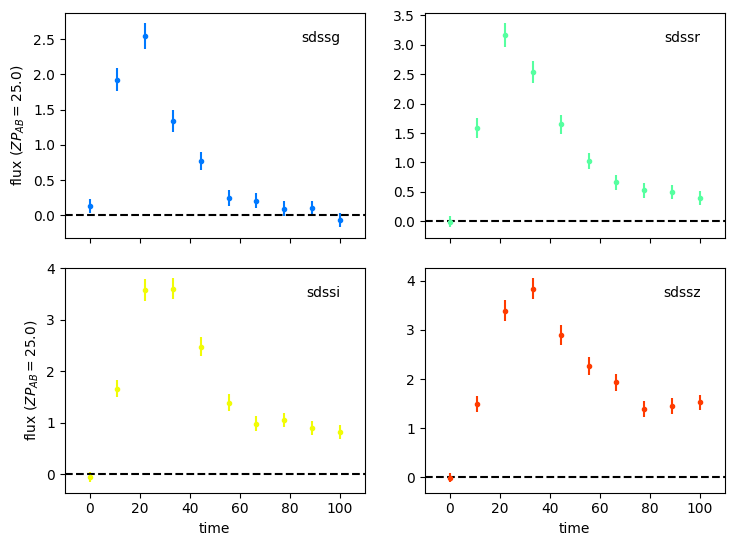

In [101]:
p = sncosmo.plot_lc(lcs[0])

In [102]:
params

{'mej': 3, 'fni': 0.1, 'vej': 10000}

In [103]:
result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['mej', 'vej', 'fni'], 
                                      bounds={'mej':(0.01, 5), 'fni':(0.05, 0.15), 'vej':(5000, 15000)},
                                     minsnr = 5.0)


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


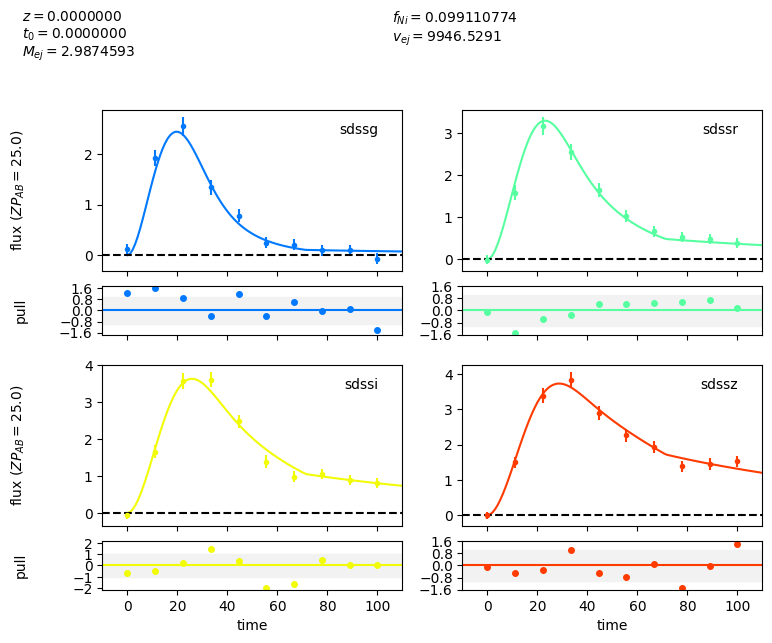

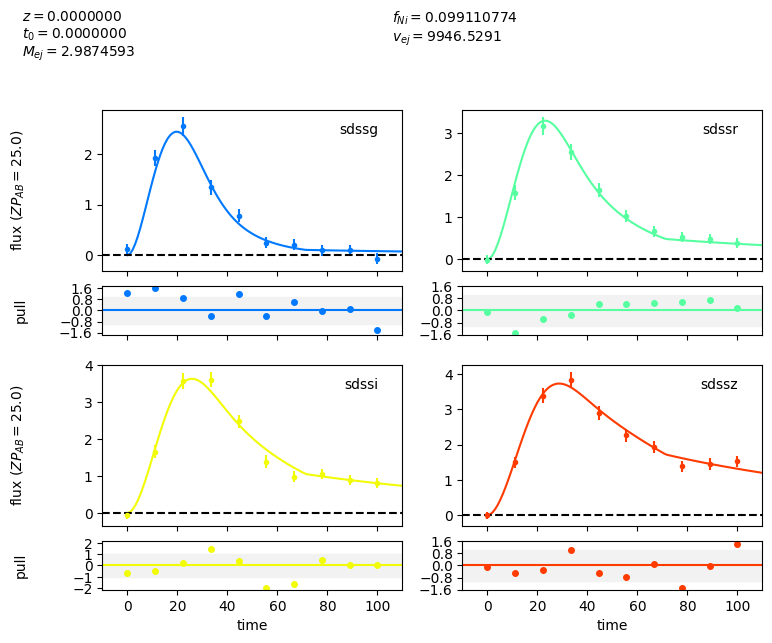

In [104]:
sncosmo.plot_lc(lcs[0], model=fitted_model)

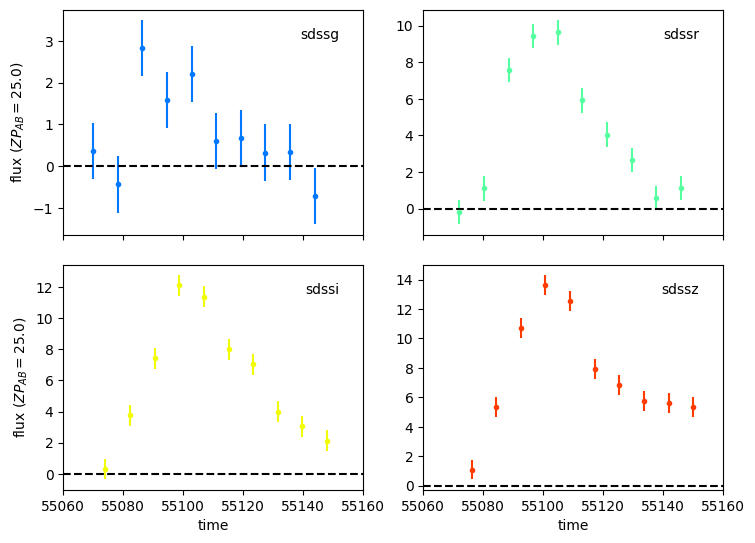

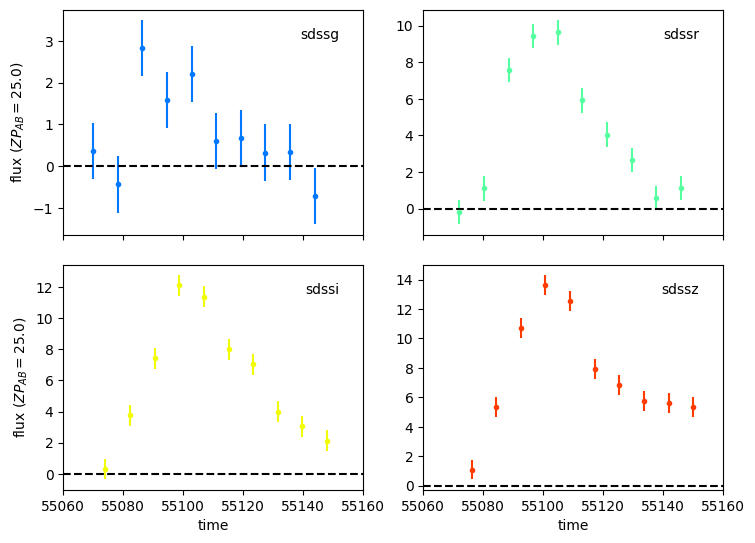

In [105]:
sncosmo.plot_lc(data)

In [58]:
model = sncosmo.Model(source='salt2')
result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
    bounds={'z':(0.3, 0.7)}) 

In [59]:
model.param_names

['z', 't0', 'x0', 'x1', 'c']

In [60]:
model = sncosmo.Model(source='nugent-sn1a')
model.param_names

['z', 't0', 'amplitude']

In [61]:
model = sncosmo.Model(source='nugent-sn1bc')
model.param_names

['z', 't0', 'amplitude']

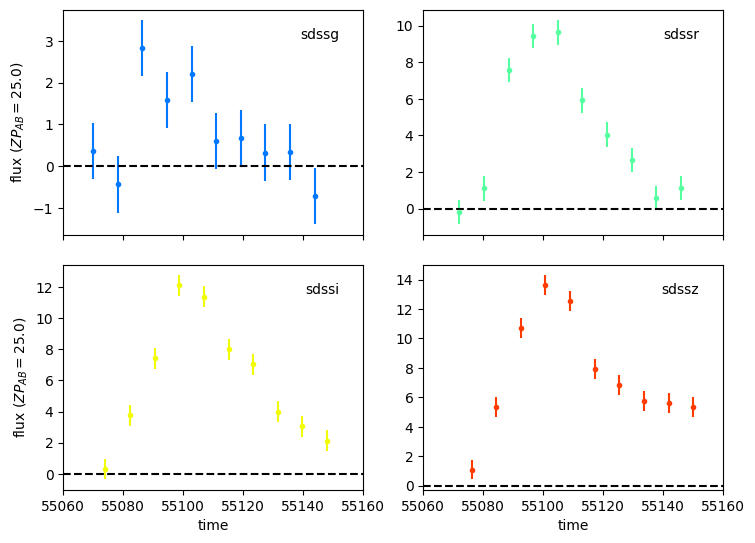

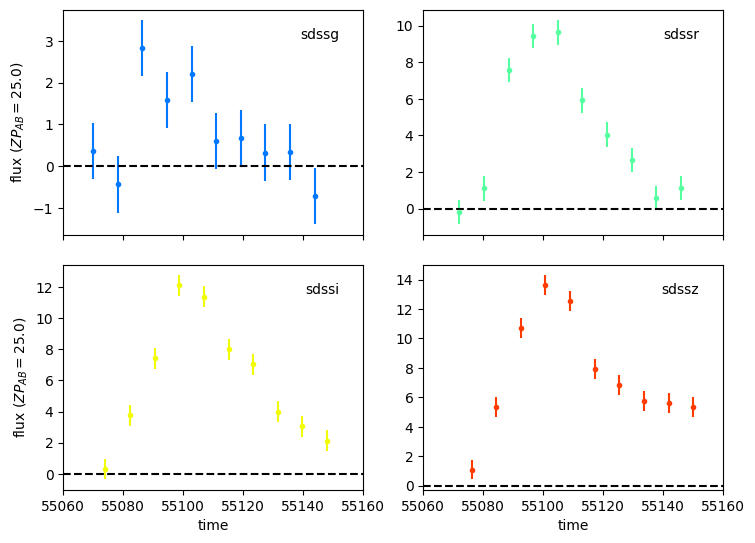

In [62]:
sncosmo.plot_lc(data)

## Arnett Model

In [49]:
t_Ni = 8.8 # days
t_Co = 111.3
t_d = 10

def integral(tprime, t_d, other_time):
    return (tprime / t_d) * np.exp(tprime**2 / t_d**2) * np.exp(-tprime/other_time)

In [50]:
eps_Ni = 3.9e10 # erg/s/g
eps_Co = 6.8e9 # erg/s/g

def arnett(t, t_d, Mni):
    Ni_integral, _ = integrate.quad(integral, 0, t, args=(t_d, t_Ni,))
    Co_integral, _ = integrate.quad(integral, 0, t, args=(t_d, t_Co,))
    
    return (2 * Mni / t_d) * np.exp(-t**2 / t_d**2) * ((eps_Ni - eps_Co) * Ni_integral + eps_Co * Co_integral)

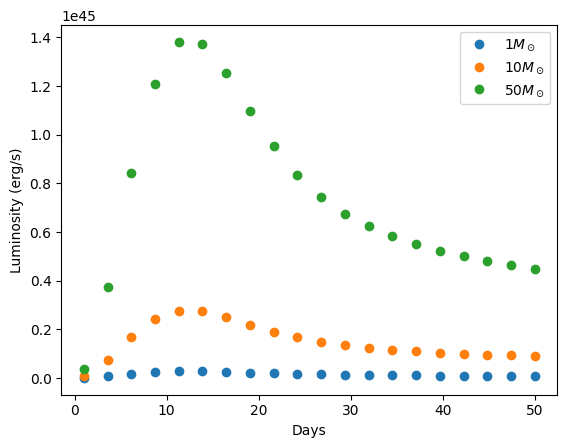

In [51]:
Msun = 2e33 # grams

times = np.linspace(1, 50, 20)
plt.plot(times, [arnett(i, 10, 1*Msun) for i in times], 'o', label="$1 M_\odot$")
plt.plot(times, [arnett(i, 10, 10*Msun) for i in times], 'o', label="$10 M_\odot$")
plt.plot(times, [arnett(i, 10, 50*Msun) for i in times], 'o', label="$50 M_\odot$")

plt.xlabel("Days")
plt.ylabel("Luminosity (erg/s)")
plt.legend()
plt.show()